In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


2025-09-28 06:07:48.546414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759039668.753727      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759039668.815326      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_dir = "/kaggle/input/telugudataset2/train"
val_dir = "/kaggle/input/telugudataset2/val"
test_dir = "/kaggle/input/telugudataset2/test"


IMG_SIZE = (128, 128)  
BATCH_SIZE = 64


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode="nearest"
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
print("✅ Number of classes:", NUM_CLASSES)


Found 43417 images belonging to 448 classes.
Found 9346 images belonging to 448 classes.
Found 9368 images belonging to 448 classes.
✅ Number of classes: 448


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

def build_cnn(input_shape=(128,128,3), num_classes=NUM_CLASSES):
    model = Sequential()

    
    model.add(Conv2D(32, (3,3), padding="same", input_shape=input_shape))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(Conv2D(32, (3,3), padding="same"))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.30))

    
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.35))

    
    model.add(Conv2D(256, (3,3), padding="same"))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(Conv2D(256, (3,3), padding="same"))
    model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.40))

    
    model.add(Flatten())
    model.add(Dense(512)); model.add(BatchNormalization()); model.add(Activation("relu"))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation="softmax"))

    return model

model = build_cnn()

try:
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    print(f"Calculated steps_per_epoch for LR schedule: {steps_per_epoch}")
except NameError:
    print("Warning: 'train_generator' not defined. Using a default value for decay steps.")
    steps_per_epoch = 678 


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,    
    decay_steps=steps_per_epoch,   
    decay_rate=0.95                
)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


print("Compiling model with Adam optimizer and ExponentialDecay learning rate schedule.")
model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1759039752.938769      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759039752.939600      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Calculated steps_per_epoch for LR schedule: 678
Compiling model with Adam optimizer and ExponentialDecay learning rate schedule.


In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("best_cnn_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)
]


In [13]:
EPOCHS = 30

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.0045 - loss: 6.3865
Epoch 1: val_accuracy improved from -inf to 0.00920, saving model to best_cnn_model.h5
679/679 ━━━━━━━━━━━━━━━━━━━━ 356s 482ms/step - accuracy: 0.0045 - loss: 6.3864 - val_accuracy: 0.0092 - val_loss: 6.0315 - learning_rate: 9.4993e-05
Epoch 2/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.0089 - loss: 6.0692
Epoch 2: val_accuracy improved from 0.00920 to 0.00984, saving model to best_cnn_model.h5
679/679 ━━━━━━━━━━━━━━━━━━━━ 241s 355ms/step - accuracy: 0.0089 - loss: 6.0692 - val_accuracy: 0.0098 - val_loss: 6.0590 - learning_rate: 9.0236e-05
Epoch 3/30
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.0121 - loss: 5.9386
Epoch 3: val_accuracy improved from 0.00984 to 0.01798, saving model to best_cnn_model.h5
679/679 ━━━━━━━━━━━━━━━━━━━━ 226s 333ms/step - accuracy: 0.0121 - loss: 5.9385 - val_accuracy: 0.0180 - val_loss: 5.7400 - learning_rate: 8.5718e-05
Epoch 4/30
679/679 ━━━

KeyboardInterrupt: 

In [ ]:
from IPython.display import FileLink


FileLink('best_cnn_model.h5')

/kaggle/working/best_cnn_model.h5

In [5]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/epoch23/best_cnn_model (2).h5")
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 32, 32, 128)    │             

 Total params: 9,797,089 (37.37 MB)

 Trainable params: 9,794,144 (37.36 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Optimizer params: 1 (8.00 B)

In [6]:
loss, acc = model.evaluate(val_generator)
print(f"Best model validation accuracy: {acc:.4f}")
print(f"Best model validation loss: {loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1758906043.611701     118 service.cc:148] XLA service 0x7d1fb8011150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758906043.617708     118 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758906043.617742     118 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758906044.094065     118 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/147 ━━━━━━━━━━━━━━━━━━━━ 20:07 8s/step - accuracy: 0.5625 - loss: 1.7966

I0000 00:00:1758906050.076622     118 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 ━━━━━━━━━━━━━━━━━━━━ 79s 484ms/step - accuracy: 0.6254 - loss: 1.6213
Best model validation accuracy: 0.6285
Best model validation loss: 1.6147


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


model = load_model("/kaggle/input/epoch23/best_cnn_model (2).h5")


try:
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    print(f"Calculated steps_per_epoch for LR schedule: {steps_per_epoch}")
except NameError:
    print("Warning: 'train_generator' not defined. Using a default value for decay steps.")
    steps_per_epoch = 678 


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3.2299543818226084e-05,    
    decay_steps=steps_per_epoch,   
    decay_rate=0.95                
)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


print("Compiling model with Adam optimizer and ExponentialDecay learning rate schedule.")
model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])



history = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=23,   # last completed epoch
    epochs=50,          # continue training up to 50
    callbacks=callbacks
)


Calculated steps_per_epoch for LR schedule: 678
Compiling model with Adam optimizer and ExponentialDecay learning rate schedule.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 24/50


I0000 00:00:1758965874.420951     128 service.cc:148] XLA service 0x4e6c99e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758965874.421514     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758965874.421538     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758965875.370209     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/679 ━━━━━━━━━━━━━━━━━━━━ 4:53:33 26s/step - accuracy: 0.3906 - loss: 2.3240

I0000 00:00:1758965890.689054     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4565 - loss: 2.2019
Epoch 24: val_accuracy improved from -inf to 0.60454, saving model to best_cnn_model.h5
679/679 ━━━━━━━━━━━━━━━━━━━━ 350s 479ms/step - accuracy: 0.4565 - loss: 2.2019 - val_accuracy: 0.6045 - val_loss: 1.6187 - learning_rate: 3.0682e-05
Epoch 25/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.4737 - loss: 2.1334
Epoch 25: val_accuracy improved from 0.60454 to 0.64038, saving model to best_cnn_model.h5
679/679 ━━━━━━━━━━━━━━━━━━━━ 215s 317ms/step - accuracy: 0.4737 - loss: 2.1334 - val_accuracy: 0.6404 - val_loss: 1.5128 - learning_rate: 2.9146e-05
Epoch 26/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4925 - loss: 2.0372
Epoch 26: val_accuracy improved from 0.64038 to 0.66381, saving model to best_cnn_model.h5
679/679 ━━━━━━━━━━━━━━━━━━━━ 212s 312ms/step - accuracy: 0.4925 - loss: 2.0373 - val_accuracy: 0.6638 - val_loss: 1.4329 - learning_rate: 2.7687e-05
Epoch 27/50
679/679 ━━━━━━━━

TypeError: This optimizer was created with a `LearningRateSchedule` object as its `learning_rate` constructor argument, hence its learning rate is not settable. If you need the learning rate to be settable, you should instantiate the optimizer with a float `learning_rate` argument.

In [ ]:
from IPython.display import FileLink


FileLink('best_cnn_model.h5')

/kaggle/working/best_cnn_model.h5

In [5]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/epoch3/best_cnn_model (3).h5")
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 32, 32, 128)    │             

 Total params: 9,797,089 (37.37 MB)

 Trainable params: 9,794,144 (37.36 MB)

 Non-trainable params: 2,944 (11.50 KB)

 Optimizer params: 1 (8.00 B)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


model = load_model("/kaggle/input/epoch3/best_cnn_model (3).h5")


try:
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    print(f"Calculated steps_per_epoch for LR schedule: {steps_per_epoch}")
except NameError:
    print("Warning: 'train_generator' not defined. Using a default value for decay steps.")
    steps_per_epoch = 678 


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=2.2544e-05,    
    decay_steps=steps_per_epoch,   
    decay_rate=0.95                
)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


print("Compiling model with Adam optimizer and ExponentialDecay learning rate schedule.")
model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])



history = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=31,   
    epochs=50,        
    callbacks=callbacks
)


Calculated steps_per_epoch for LR schedule: 678
Compiling model with Adam optimizer and ExponentialDecay learning rate schedule.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 32/50


I0000 00:00:1759032037.349763     121 service.cc:148] XLA service 0x7af390002080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759032037.350626     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759032037.350646     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759032038.292727     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/679 ━━━━━━━━━━━━━━━━━━━━ 4:54:37 26s/step - accuracy: 0.4844 - loss: 1.9346

I0000 00:00:1759032054.267803     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5330 - loss: 1.8524
Epoch 33: val_accuracy improved from 0.68917 to 0.69987, saving model to best_cnn_model.h5
679/679 ━━━━━━━━━━━━━━━━━━━━ 205s 301ms/step - accuracy: 0.5330 - loss: 1.8524 - val_accuracy: 0.6999 - val_loss: 1.2549 - learning_rate: 2.0343e-05
Epoch 34/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.5429 - loss: 1.8123
Epoch 34: val_accuracy improved from 0.69987 to 0.71763, saving model to best_cnn_model.h5
679/679 ━━━━━━━━━━━━━━━━━━━━ 202s 297ms/step - accuracy: 0.5429 - loss: 1.8123 - val_accuracy: 0.7176 - val_loss: 1.1972 - learning_rate: 1.9324e-05
Epoch 35/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5570 - loss: 1.7703
Epoch 35: val_accuracy did not improve from 0.71763
679/679 ━━━━━━━━━━━━━━━━━━━━ 203s 299ms/step - accuracy: 0.5570 - loss: 1.7703 - val_accuracy: 0.7136 - val_loss: 1.1973 - learning_rate: 1.8357e-05
Epoch 36/50
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accurac

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam


model = load_model("/kaggle/working/best_cnn_model.h5")


try:
    steps_per_epoch = train_generator.samples // train_generator.batch_size
    print(f"Calculated steps_per_epoch for LR schedule: {steps_per_epoch}")
except NameError:
    print("Warning: 'train_generator' not defined. Using a default value for decay steps.")
    steps_per_epoch = 678 


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=8.4948e-06,    
    decay_steps=steps_per_epoch,   
    decay_rate=0.95               
)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


print("Compiling model with Adam optimizer and ExponentialDecay learning rate schedule.")
model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])



history = model.fit(
    train_generator,
    validation_data=val_generator,
    initial_epoch=50,   
    epochs=75,          
    callbacks=callbacks
)


Calculated steps_per_epoch for LR schedule: 678
Compiling model with Adam optimizer and ExponentialDecay learning rate schedule.
Epoch 51/75
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6200 - loss: 1.4667
Epoch 51: val_accuracy did not improve from 0.76653
679/679 ━━━━━━━━━━━━━━━━━━━━ 223s 306ms/step - accuracy: 0.6200 - loss: 1.4667 - val_accuracy: 0.7468 - val_loss: 1.0374 - learning_rate: 8.0694e-06
Epoch 52/75
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.6249 - loss: 1.4419
Epoch 52: val_accuracy did not improve from 0.76653
679/679 ━━━━━━━━━━━━━━━━━━━━ 205s 301ms/step - accuracy: 0.6249 - loss: 1.4419 - val_accuracy: 0.7448 - val_loss: 1.0118 - learning_rate: 7.6654e-06
Epoch 53/75
679/679 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.6268 - loss: 1.4385
Epoch 53: val_accuracy improved from 0.76653 to 0.76739, saving model to best_cnn_model.h5
679/679 ━━━━━━━━━━━━━━━━━━━━ 209s 308ms/step - accuracy: 0.6268 - loss: 1.4385 - val_accuracy: 0.7674 - val_los

In [7]:
loss, acc = model.evaluate(val_generator)
print(f"Best model validation accuracy: {acc:.4f}")
print(f"Best model validation loss: {loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 76s 486ms/step - accuracy: 0.7716 - loss: 0.9470
Best model validation accuracy: 0.7665
Best model validation loss: 0.9539


In [8]:
loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")


147/147 ━━━━━━━━━━━━━━━━━━━━ 72s 490ms/step - accuracy: 0.7847 - loss: 0.9171
✅ Test Accuracy: 0.7674, Test Loss: 0.9633


Reading notebook file from: /kaggle/input/saved-version-final/dlproject-process (4).ipynb
✅ Successfully extracted data for 58 epochs across all training runs.


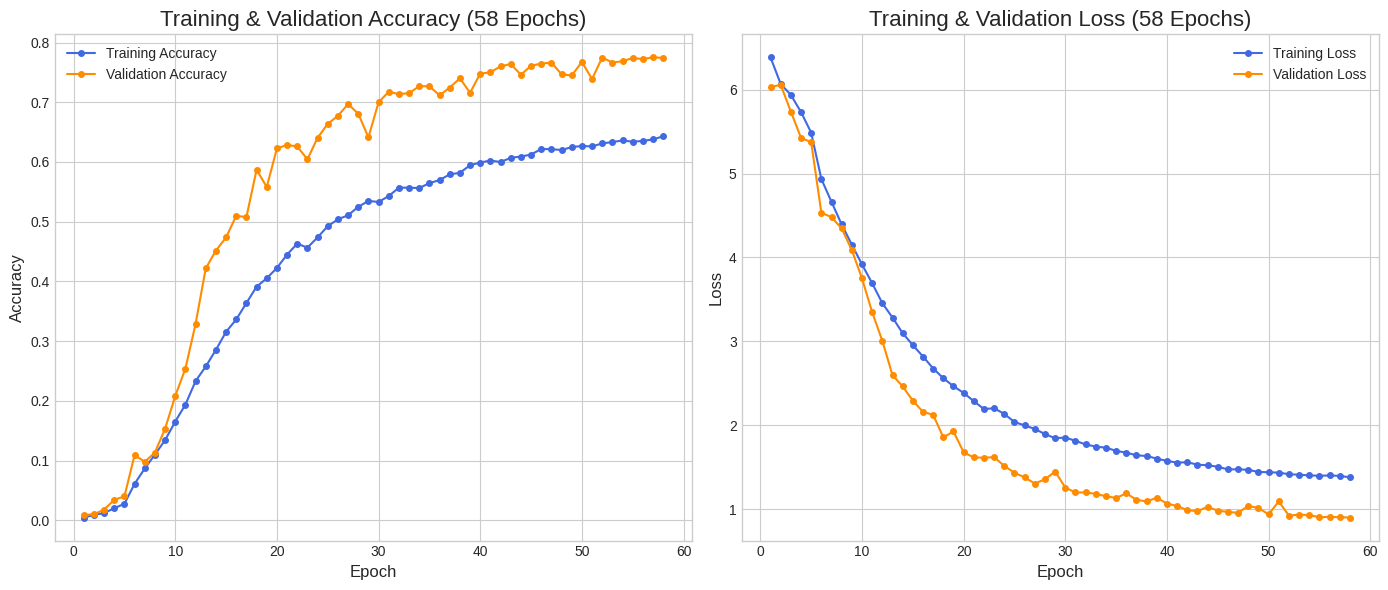

In [ ]:
import json
import re
import matplotlib.pyplot as plt
import numpy as np



notebook_path = '/kaggle/input/saved-version-final/dlproject-process (4).ipynb' 


reconstructed_history = {
    'accuracy': [], 'val_accuracy': [],
    'loss': [], 'val_loss': []
}
all_matches = []

try:
  
    print(f"Reading notebook file from: {notebook_path}")
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook_data = json.load(f)

   
    for cell in notebook_data['cells']:
        
        if 'model.fit' in "".join(cell.get('source', '')):
            training_output_text = ''
            if 'outputs' in cell:
                for output in cell['outputs']:
                   
                    if output.get('output_type') == 'stream' and output.get('name') == 'stdout':
                        training_output_text += "".join(output.get('text', ''))
            
          
            if training_output_text:
                
                pattern = r"accuracy: ([\d.]+) - loss: ([\d.]+) - val_accuracy: ([\d.]+) - val_loss: ([\d.]+)"
                matches = re.findall(pattern, training_output_text)
                if matches:
                   
                    all_matches.extend(matches)

    
    if all_matches:
        print(f"✅ Successfully extracted data for {len(all_matches)} epochs across all training runs.")
        for match in all_matches:
            reconstructed_history['accuracy'].append(float(match[0]))
            reconstructed_history['loss'].append(float(match[1]))
            reconstructed_history['val_accuracy'].append(float(match[2]))
            reconstructed_history['val_loss'].append(float(match[3]))
    else:
        print("❌ Could not find any training output in the notebook file.")

except FileNotFoundError:
    print(f"❌ ERROR: File not found at '{notebook_path}'.")
    print("Please make sure the path is correct and the file is available.")
except json.JSONDecodeError:
    print("❌ ERROR: Could not read the notebook file. It might be corrupted.")



if reconstructed_history['accuracy']:
    acc = reconstructed_history['accuracy']
    val_acc = reconstructed_history['val_accuracy']
    loss = reconstructed_history['loss']
    val_loss = reconstructed_history['val_loss']
    
    
    epochs_range = range(1, len(acc) + 1)

 
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'o-', label='Training Accuracy', color='royalblue', markersize=4)
    plt.plot(epochs_range, val_acc, 'o-', label='Validation Accuracy', color='darkorange', markersize=4)
    plt.title(f'Training & Validation Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'o-', label='Training Loss', color='royalblue', markersize=4)
    plt.plot(epochs_range, val_loss, 'o-', label='Validation Loss', color='darkorange', markersize=4)
    plt.title(f'Training & Validation Loss ({len(acc)} Epochs)', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

I0000 00:00:1759040455.456598     122 service.cc:148] XLA service 0x7a754c001d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759040455.459050     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759040455.459070     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759040455.689913     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Model predictions (probabilities): [[2.44450987e-10 6.60850931e-12 3.38939787e-09 5.35514300e-09
  3.12153219e-08 1.19591992e-09 1.96154974e-06 2.96897866e-08
  7.84296361e-09 5.85904658e-09 3.20593448e-04 9.97152777e-11
  7.17852799e-06 4.47932713e-08 5.08429565e-09 2.41804560e-06
  8.19724821e-09 6.33919861e-10 1.04538184e-10 4.71211905e-08
  1.90995483e-10 2.60995790e-07 1.73488013e-09 1.47361456e-10
  2.93297990e-11 2.17608225e-08 3.47453688e-09 6.70307330e-08
  7.75274245e-09 1.17033629e-07 4.48105952e-09 9.36640987e-09
  4.71619249e-04 5.48087087e-09 4.02813310e-10 1.90514493e-10
  3.64321767e-11 1.99665195e-09 2.45506532e-10 1.43985681e-05
  1.17370391e-09 9.25565388e-11 1.08734185e-11 4.12062051e-11
  5.43352974e-10 5.68981390e-11 8.16582826e-07 3.46743469e-08
  2.08698081e-09 8.85101130e-08 9.71094494e-08 2.33451960e-08
  1.48015147e-08 2.17527596e-09 8.52547644e-10 1.72337093e-06
  3.10763717e-08 9.40427025e-09 1.00670411e-06 6.04749573e-07

I0000 00:00:1759040457.768564     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


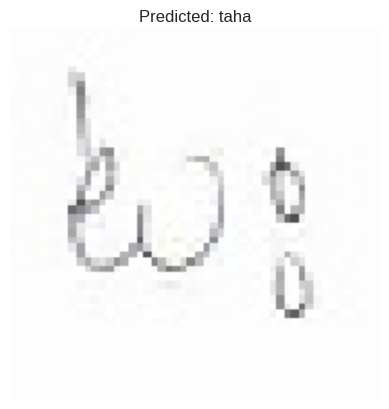

✅ Final Prediction: taha


In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


model = tf.keras.models.load_model("/kaggle/input/epoch4/best_cnn_model (4).h5")

class_labels=list(train_generator.class_indices.keys())


img_path = "/kaggle/input/prediction/TEST3.jpg"


img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)



predictions = model.predict(img_array)
print("Model predictions (probabilities):", predictions)
predicted_index = np.argmax(predictions, axis=1)[0]
predicted_class = class_labels[predicted_index]


plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted: {predicted_class}")
plt.show()

print(f"✅ Final Prediction: {predicted_class}")